In [141]:
import os

import cv2
# reload extension
%reload_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import skimage.io
import skimage.exposure
import scipy
from skimage.metrics import peak_signal_noise_ratio as psnr
from utils import load_scan
from skimage.transform import downscale_local_mean

In [142]:
def contact_area(image, label1, label2):
    """Counts the number of surfaces of label1 in contact with label2.
    
    Args:
        image(numpy.ndarray): Array representing image (or image stack). 
        label1(int): Value of label 1
        label1(int): Value of label 2
  
    Returns: 
        int: Number of voxels of label1 in contact with label2
    """

    histogram = skimage.exposure.histogram(image)

    if label1 not in histogram[1] or label2 not in histogram[1]:
        raise ValueError('One or more labels do not exist. Please input valid labels.')

    x_contact_1 = np.logical_and(image[:, :, :-1] == label1, image[:, :, 1:] == label2)
    x_contact_2 = np.logical_and(image[:, :, :-1] == label2, image[:, :, 1:] == label1)
    y_contact_1 = np.logical_and(image[:, :-1, :] == label1, image[:, 1:, :] == label2)
    y_contact_2 = np.logical_and(image[:, :-1, :] == label2, image[:, 1:, :] == label1)
    z_contact_1 = np.logical_and(image[:-1, :, :] == label1, image[1:, :, :] == label2)
    z_contact_2 = np.logical_and(image[:-1, :, :] == label2, image[1:, :, :] == label1)
    #np.argwhere(hpairs) - counts each pair which is in contact

    contact_voxels = np.count_nonzero(x_contact_1) + np.count_nonzero(x_contact_2) \
                     + np.count_nonzero(y_contact_1) + np.count_nonzero(y_contact_2) \
                     + np.count_nonzero(z_contact_1) + np.count_nonzero(z_contact_2)

    return contact_voxels

def apply_threshold_between(image, threshold: tuple):
    """Applies a threshold to an image (or image stack).
    
    Args:
        image(numpy.ndarray): Array representing image (or image stack). 
        threshold(int): Value of threshold
  
    Returns: 
        numpy.ndarray: Array with threshold applied to image
    """
    # use skimage image_as_ubyte

    if image.dtype != np.uint8:
        image = skimage.util.img_as_ubyte(image)
    
    thresholded_image = np.logical_and(image >= threshold[0], image <= threshold[1]).astype(np.uint8)

    return thresholded_image

def show_image(image):
    """Displays an image (or image stack).
    
    Args:
        image(numpy.ndarray): Array representing image (or image stack). 
    """
    h, w = image.shape
    new_w = h*6
    offset = (w-new_w)//2
    fig, axs = plt.subplots(2, 1, figsize=(10, 5))
    fig.subplots_adjust(hspace=0.1)
    axs[0].imshow(image[:, offset:offset+new_w], cmap='gray')
    axs[0].axis('off')
    
    # np.hist
    counts, edges = np.histogram(image, bins=256)
    axs[1].bar(edges[:-1], counts, width=np.diff(edges), align="edge")
    axs[1].set_yscale('log')
    plt.tight_layout()
    plt.show()

def apply_median(image, radius):
    """Applies a median filter to an image (or image stack).
    
    Args:
        image(numpy.ndarray): Array representing image (or image stack). 
        radius(int): Value of radius
  
    Returns: 
        numpy.ndarray: Array with median filter applied to image
    """
    
    median_image = scipy.ndimage.median_filter(image, size=radius)

    return median_image

def apply_nlm(image, h=10, search_window=7, block_size=21):
    import cv2 as cv
    image = skimage.util.img_as_ubyte(image)
    nlm_image = cv.fastNlMeansDenoising(image, None, h, search_window, block_size)
    return nlm_image

In [143]:
path = "../../../04_uCT/AD36/SlicesY-20240903_AD36/"

Loading images from:  ../../../04_uCT/AD36/SlicesY-20240903_AD36/
Loaded stack with the shape (1780, 205, 2214) and a size of 1.62 GB in 20.45 s.


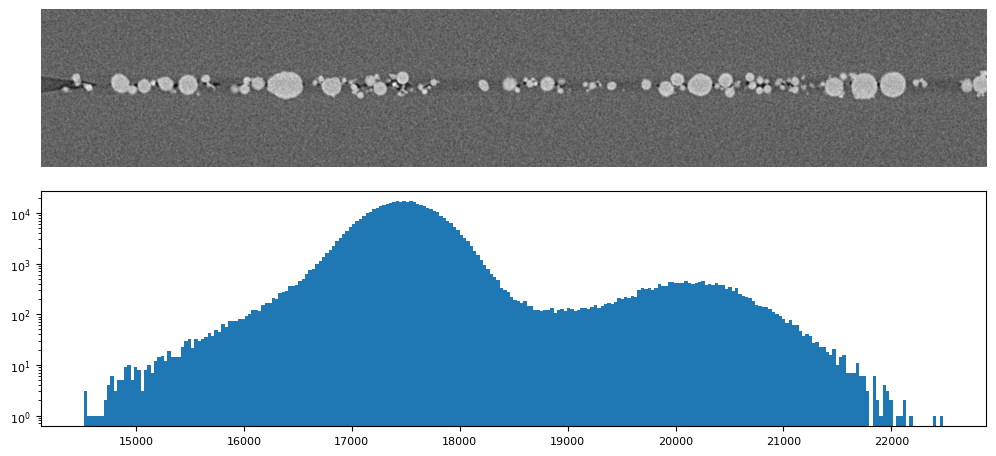

In [144]:
stack = load_scan(path, logging=True)
show_image(stack[500])

In [145]:
im = stack[500]

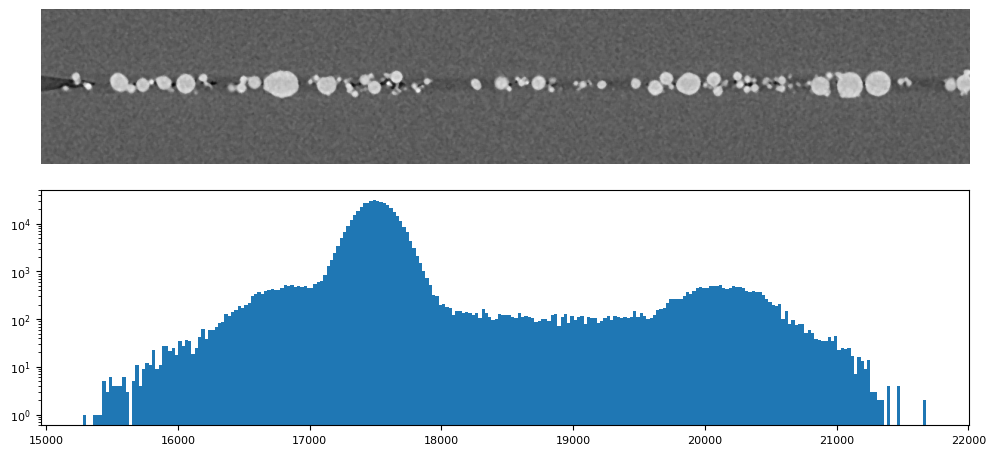

46.89201548249799


In [146]:
med_filtered = apply_median(stack[500], 4)
show_image(med_filtered)
print(psnr(stack[500], med_filtered))

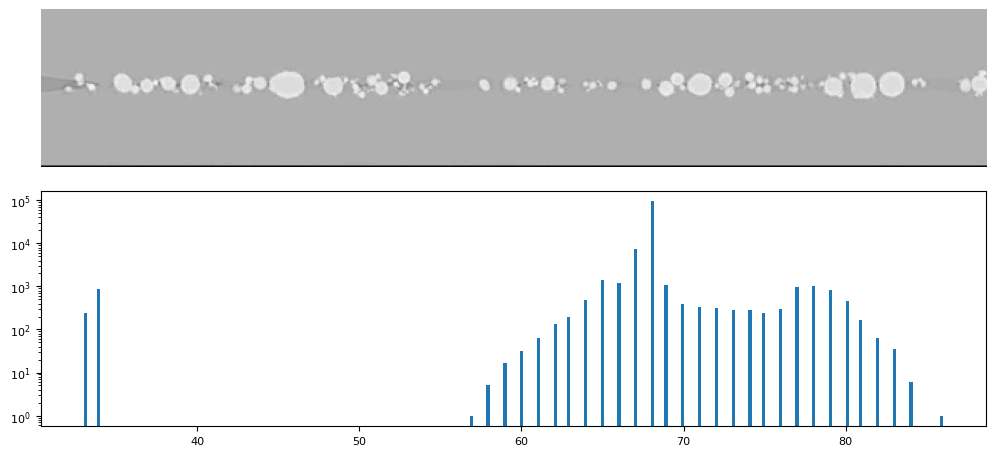

ValueError: Input images must have the same dimensions.

In [162]:
im = downscale_local_mean(stack[500], 2).astype(np.uint16)
nlm_filtered = apply_nlm(im, h=1)
show_image(nlm_filtered)
print(psnr(skimage.util.img_as_ubyte(stack[500]), nlm_filtered))
plt.imsave("nlm_filtered.png", nlm_filtered, cmap='gray')

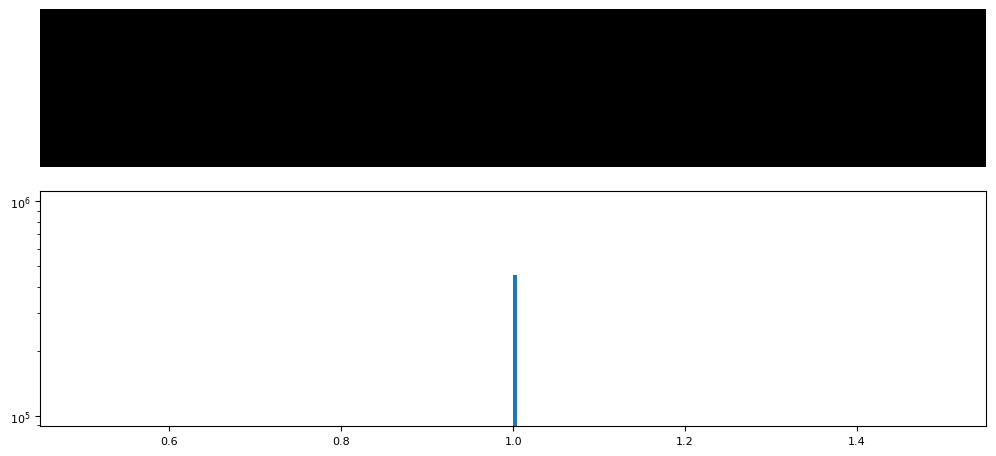

In [155]:
thresholded = apply_threshold_between(nlm_filtered, (0, 100))
show_image(thresholded)

In [149]:
from skimage.io import imread
from pyclesperanto_prototype import imshow
import pyclesperanto_prototype as cle
import matplotlib.pyplot as plt

In [150]:
cle.select_device("TX")

<NVIDIA GeForce RTX 3060 Laptop GPU on Platform: NVIDIA CUDA (1 refs)>

In [151]:
def show(image_to_show, labels=False):
    """
    This function generates three projections: in X-, Y- and Z-direction and shows them.
    """
    projection_x = cle.maximum_x_projection(image_to_show)
    projection_y = cle.maximum_y_projection(image_to_show)
    projection_z = cle.maximum_z_projection(image_to_show)

    fig, axs = plt.subplots(1, 3, figsize=(15, 15))
    cle.imshow(projection_x, plot=axs[0], labels=labels)
    cle.imshow(projection_y, plot=axs[1], labels=labels)
    cle.imshow(projection_z, plot=axs[2], labels=labels)
    plt.show()

C:\Users\malte\anaconda3\envs\thesis\Lib\site-packages\pyclesperanto_prototype\_tier9\_imshow.py:35: UserWarning: cle.imshow is deprecated, use stackview.imshow instead.
  warnings.warn("cle.imshow is deprecated, use stackview.imshow instead.")


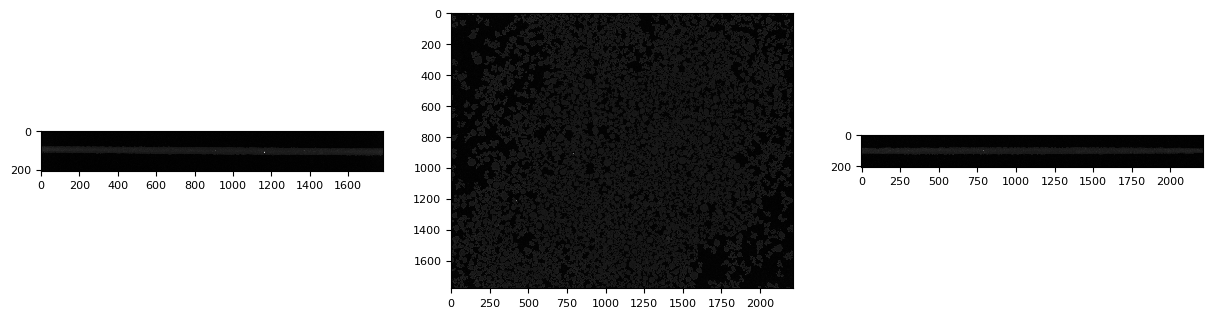

In [152]:
stack = load_scan(path)
show(stack)

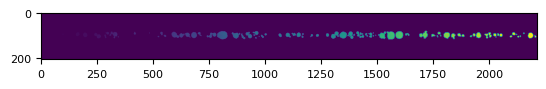

In [153]:
segmented = cle.voronoi_otsu_labeling(stack[500], spot_sigma=3, outline_sigma=1)
plt.imshow(segmented)
# show(segmented, labels=True)


In [154]:
h, w = segmented[0].shape
new_w = h*4
offset = (w-new_w)//2
fig, axs = plt.subplots(4, 4, figsize=(20, 6))
axs = axs.ravel()
for i in range(16):
    cle.imshow(segmented[i][:, offset:offset+new_w], plot=axs[i], labels=True)
    axs[i].axis('off')

ValueError: not enough values to unpack (expected 2, got 1)

In [ ]:
plt.imshow(stack[0])

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from skimage import data, img_as_float
from skimage import exposure

matplotlib.rcParams['font.size'] = 8


def plot_img_and_hist(image, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram."""
    image = img_as_float(image)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(image, cmap=plt.cm.gray)
    ax_img.set_axis_off()

    # Display histogram
    ax_hist.hist(image.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(image, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf


# Load an example image
img = nlm_filtered

# Gamma
gamma_corrected = exposure.adjust_gamma(img, 2)

# Logarithmic
logarithmic_corrected = exposure.adjust_log(img, 1)

# Display results
fig = plt.figure(figsize=(8, 5))
axes = np.zeros((2, 3), dtype=object)
axes[0, 0] = plt.subplot(2, 3, 1)
axes[0, 1] = plt.subplot(2, 3, 2, sharex=axes[0, 0], sharey=axes[0, 0])
axes[0, 2] = plt.subplot(2, 3, 3, sharex=axes[0, 0], sharey=axes[0, 0])
axes[1, 0] = plt.subplot(2, 3, 4)
axes[1, 1] = plt.subplot(2, 3, 5)
axes[1, 2] = plt.subplot(2, 3, 6)

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:, 0])
ax_img.set_title('Low contrast image')

y_min, y_max = ax_hist.get_ylim()
ax_hist.set_ylabel('Number of pixels')
ax_hist.set_yticks(np.linspace(0, y_max, 5))

ax_img, ax_hist, ax_cdf = plot_img_and_hist(gamma_corrected, axes[:, 1])
ax_img.set_title('Gamma correction')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(logarithmic_corrected, axes[:, 2])
ax_img.set_title('Logarithmic correction')

ax_cdf.set_ylabel('Fraction of total intensity')
ax_cdf.set_yticks(np.linspace(0, 1, 5))

# prevent overlap of y-axis labels
fig.tight_layout()
plt.savefig("contrast_correction.png", dpi=900)
plt.show()


In [ ]:
img = apply_nlm(stack[500], h=20, search_window=3, block_size=21)
p2, p98 = np.percentile(img, (2, 98))
img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))
show_image(img_rescale)
print(psnr(skimage.util.img_as_ubyte(stack[500]), nlm_filtered))
plt.imsave("nlm_filtered.png", img_rescale, cmap='gray')

In [ ]:
import cv2 as cv2
particle_mask = apply_threshold_between(img_rescale, (106, 255))
air_mask = apply_threshold_between(img_rescale, (0, 42))
polymer_mask = apply_threshold_between(img_rescale, (43, 106))
fig, axs = plt.subplots(3, figsize=(20, 6))
axs[0].imshow(particle_mask, cmap='gray')
axs[0].set_title('Particle mask')
axs[1].imshow(air_mask, cmap='gray')
axs[1].set_title('Air mask')
axs[2].imshow(~polymer_mask, cmap='gray')
axs[2].set_title('Polymer mask')
plt.show()


# particle_mask = skimage.morphology.binary_closing(particle_mask, selem=skimage.morphology.disk(2))
# air_mask = skimage.morphology.binary_closing(air_mask, selem=skimage.morphology.disk(2))
polymer_mask = ~cv2.morphologyEx(~polymer_mask, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (4, 4)))

air_mask[np.logical_and(air_mask, polymer_mask)] = 0
particle_mask = np.logical_or(air_mask, polymer_mask)
particle_mask = cv2.morphologyEx(particle_mask.astype(np.uint8), cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3)))


overlay = np.logical_and(particle_mask, air_mask)


fig, axs = plt.subplots(4, figsize=(20, 6))
axs[0].imshow(~particle_mask, cmap='gray')
axs[0].set_title('Particle mask')
axs[1].imshow(air_mask, cmap='gray')
axs[1].set_title('Air mask')
axs[2].imshow(polymer_mask, cmap='gray')
axs[2].set_title('Polymer mask')
axs[3].imshow(overlay, cmap='gray')
plt.show()


In [ ]:
~np.array([True, False])


In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from skimage import data, img_as_float
from skimage import exposure


matplotlib.rcParams['font.size'] = 8


def plot_img_and_hist(image, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram."""
    image = img_as_float(image)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(image, cmap=plt.cm.gray)
    ax_img.set_axis_off()

    # Display histogram
    ax_hist.hist(image.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(image, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf


# Load an example image

# Contrast stretching
p2, p98 = np.percentile(img, (2, 98))
img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))

# Equalization
img_eq = exposure.equalize_hist(img)

# Adaptive Equalization
img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)

# Display results
fig = plt.figure(figsize=(8, 5))
axes = np.zeros((2, 4), dtype=object)
axes[0, 0] = fig.add_subplot(2, 4, 1)
for i in range(1, 4):
    axes[0, i] = fig.add_subplot(2, 4, 1 + i, sharex=axes[0, 0], sharey=axes[0, 0])
for i in range(0, 4):
    axes[1, i] = fig.add_subplot(2, 4, 5 + i)

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:, 0])
ax_img.set_title('Low contrast image')

y_min, y_max = ax_hist.get_ylim()
ax_hist.set_ylabel('Number of pixels')
ax_hist.set_yticks(np.linspace(0, y_max, 5))

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_rescale, axes[:, 1])
ax_img.set_title('Contrast stretching')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_eq, axes[:, 2])
ax_img.set_title('Histogram equalization')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_adapteq, axes[:, 3])
ax_img.set_title('Adaptive equalization')

ax_cdf.set_ylabel('Fraction of total intensity')
ax_cdf.set_yticks(np.linspace(0, 1, 5))

# prevent overlap of y-axis labels
fig.tight_layout()
plt.savefig("contrast_correction.png", dpi=900)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from skimage import data, filters

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(30, 4))

image = im
edges = filters.sobel(image)

low = 0.1
high = 0.35

lowt = (edges > low).astype(int)
hight = (edges > high).astype(int)
hyst = filters.apply_hysteresis_threshold(edges, low, high)
ax[0, 0].imshow(image, cmap='gray')
ax[0, 0].set_title('Original image')

ax[0, 1].imshow(edges, cmap='magma')
ax[0, 1].set_title('Sobel edges')

ax[1, 0].imshow(lowt, cmap='magma')
ax[1, 0].set_title('Low threshold')

ax[1, 1].imshow(hight + hyst, cmap='magma')
ax[1, 1].set_title('Hysteresis threshold')

for a in ax.ravel():
    a.axis('off')

plt.tight_layout()

plt.show()

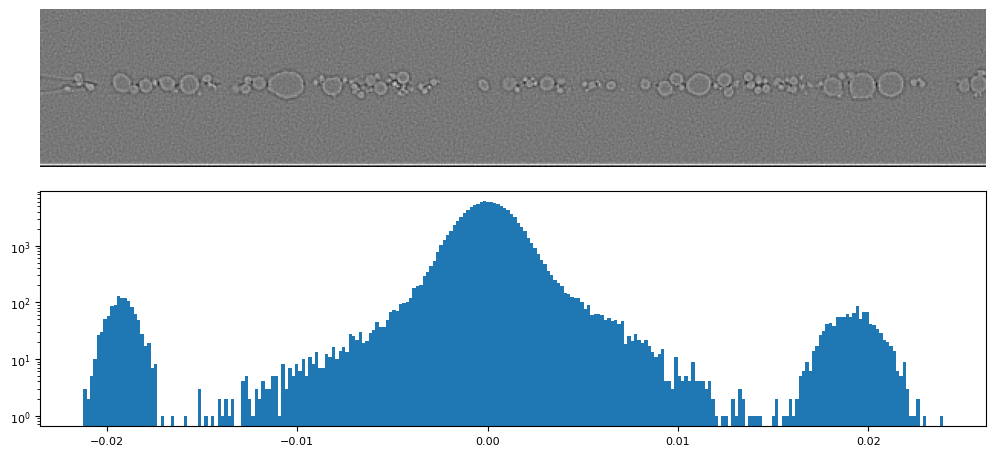

In [165]:
from skimage.filters import difference_of_gaussians


dog = difference_of_gaussians(im, 0.5)
show_image(dog)

ValueError: the input array must have size 3 along `channel_axis`, got (103, 1107)

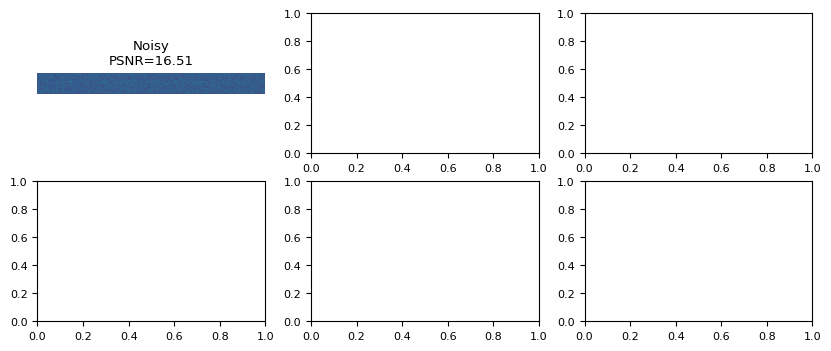

In [168]:
import matplotlib.pyplot as plt

from skimage.restoration import denoise_wavelet, cycle_spin
from skimage.util import random_noise, img_as_float
from skimage.metrics import peak_signal_noise_ratio


original = img_as_float(im.copy())

sigma = 0.155
noisy = random_noise(original, var=sigma**2)

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10, 4), sharex=False, sharey=False)
ax = ax.ravel()

psnr_noisy = peak_signal_noise_ratio(original, noisy)
ax[0].imshow(noisy)
ax[0].axis('off')
ax[0].set_title(f'Noisy\nPSNR={psnr_noisy:0.4g}')


# Repeat denosing with different amounts of cycle spinning.  e.g.
# max_shift = 0 -> no cycle spinning
# max_shift = 1 -> shifts of (0, 1) along each axis
# max_shift = 3 -> shifts of (0, 1, 2, 3) along each axis
# etc...

denoise_kwargs = dict(
    channel_axis=-1, convert2ycbcr=True, wavelet='db1', rescale_sigma=True
)

all_psnr = []
max_shifts = [0, 1, 3, 5]
for n, s in enumerate(max_shifts):
    im_bayescs = cycle_spin(
        noisy,
        func=denoise_wavelet,
        max_shifts=s,
        func_kw=denoise_kwargs,
        channel_axis=-1,
    )
    ax[n + 1].imshow(im_bayescs)
    ax[n + 1].axis('off')
    psnr = peak_signal_noise_ratio(original, im_bayescs)
    if s == 0:
        ax[n + 1].set_title(f'Denoised: no cycle shifts\nPSNR={psnr:0.4g}')
    else:
        ax[n + 1].set_title(f'Denoised: {s+1}x{s+1} shifts\nPSNR={psnr:0.4g}')
    all_psnr.append(psnr)

# plot PSNR as a function of the degree of cycle shifting
ax[5].plot(max_shifts, all_psnr, 'k.-')
ax[5].set_ylabel('PSNR (dB)')
ax[5].set_xlabel('max cycle shift along each axis')
ax[5].grid(True)
plt.subplots_adjust(wspace=0.35, hspace=0.35)

# Annotate with a cyan arrow on the 6x6 case vs. no cycle shift case to
# illustrate a region with reduced block-like artifact with cycle shifting
arrowprops = dict(
    arrowstyle="simple,tail_width=0.1,head_width=0.5", connectionstyle="arc3", color='c'
)
for i in [1, 4]:
    ax[i].annotate(
        "",
        xy=(101, 39),
        xycoords='data',
        xytext=(70, 70),
        textcoords='data',
        arrowprops=arrowprops,
    )

plt.show()